# Brain Tumor Classification - Baseline CNN Model

This notebook implements a baseline CNN model for brain tumor classification using PyTorch. We'll use the preprocessed brain tumor MRI dataset to train and evaluate a simple CNN architecture.

## 1. Setup and Imports

In [1]:
# Data processing
import numpy as np
import os

# PyTorch imports
import torch

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Use os.path.join to avoid manual path issues
path = os.path.join('gdrive', 'My Drive', 'Erdos', 'brainnet-medical-imaging', 'src')

# Change directory
# os.getcwd()
os.chdir(path)

In [5]:
# Use this if running locally
# import our own modules
# import sys
# sys.path.append('../src')  # Add the src directory to the Python path


# import data
from config.data import data_setup, data_loader
from models.cnn import BrainTumorCNN #CNNModel
from utils.prediction import train_model, predict_single_image, conf_matrix, summary
from utils.visualization import plot_training_history

Using device: cuda
Using device: cuda


## 2. Data Loading and Preprocessing

In [16]:
# Load data and data_loaders
train_set, test_set, label_conversion_dict = data_setup()

<ipython-input-15-35b3e3c7134c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['label'] = df_unique['filepath'].apply(lambda x: x.split('/')[-2])
<ipython-input-15-35b3e3c7134c>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['class'] = df_unique['filename'].apply(lambda x: 'train' if x[:2] == 'Tr' else 'test')
100%|██████████| 6726/6726 [00:06<00:00, 969.08it/s] 


Initial number of samples in train set: 5580
Initial number of samples in test set: 1285
Total samples in train set after overriding labels: 5521
Total samples in test set after overriding labels: 1205
Total files in train set: 5521, with target values: [0, 1, 2, 3]
Total files in test set: 1205, with target values: [0, 1, 2, 3]


In [18]:
train_loader, test_loader = data_loader(train_set, test_set)

# Extract the class labels from the dictionary keys
class_labels = list(label_conversion_dict.keys())[:4]

## 3. Model Architecture

Our baseline model is a simple CNN with four convolutional blocks and two fully connected layers.

*   Convolutional Blocks: Each block (Conv → BatchNorm → LeakyReLU → MaxPool) progressively extracts features and reduces image dimensions
*   Fully Connected Layers & Dropout: The FC layers, with dropout in between, help the model generalize and prevent overfitting
*   Overall: This design is lightweight and fast to train, providing a solid baseline to compare against more complex or pre-trained architectures in the future

In [20]:
# Initialize model
model_cnn = BrainTumorCNN().to(device)
print(model_cnn)

BrainTumorCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

## 4. Model Training and Evaluation

Here we initialize our model, loss function, optimizer, and learning rate scheduler. We then train the model using our defined training function.



In [21]:
# Train the model
history = train_model(
    model=model_cnn,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=10
)

Epoch 1/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 1/10:
Train Loss: 0.7098, Val Loss: 0.5312, Accuracy: 77.18%


Epoch 2/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 2/10:
Train Loss: 0.4238, Val Loss: 0.3998, Accuracy: 83.24%


Epoch 3/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 3/10:
Train Loss: 0.3370, Val Loss: 0.3280, Accuracy: 87.14%


Epoch 4/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 4/10:
Train Loss: 0.2560, Val Loss: 0.2780, Accuracy: 89.21%


Epoch 5/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 5/10:
Train Loss: 0.2044, Val Loss: 0.3167, Accuracy: 88.22%


Epoch 6/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 6/10:
Train Loss: 0.1708, Val Loss: 0.4045, Accuracy: 84.32%


Epoch 7/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 7/10:
Train Loss: 0.1449, Val Loss: 0.2520, Accuracy: 91.04%


Epoch 8/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 8/10:
Train Loss: 0.1011, Val Loss: 0.2056, Accuracy: 92.20%


Epoch 9/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 9/10:
Train Loss: 0.0994, Val Loss: 0.4458, Accuracy: 86.47%


Epoch 10/10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 10/10:
Train Loss: 0.1004, Val Loss: 0.1501, Accuracy: 94.77%


## 5. Visualizing Results

We visualize the training and validation metrics to understand how our model performs over time. This includes:
- Training and validation loss curves
- Validation accuracy progression

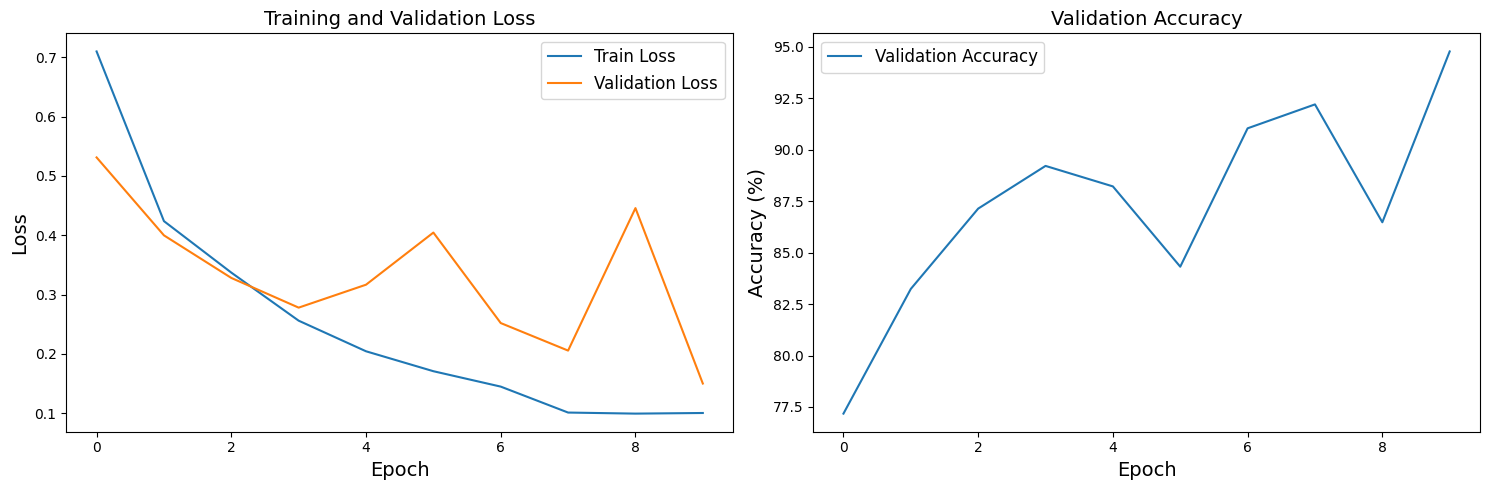

In [22]:
# Plot training history
plot_training_history(history)

We now test our model on an example image from the test set and visualize the results. This helps us understand how the model performs on specific examples.

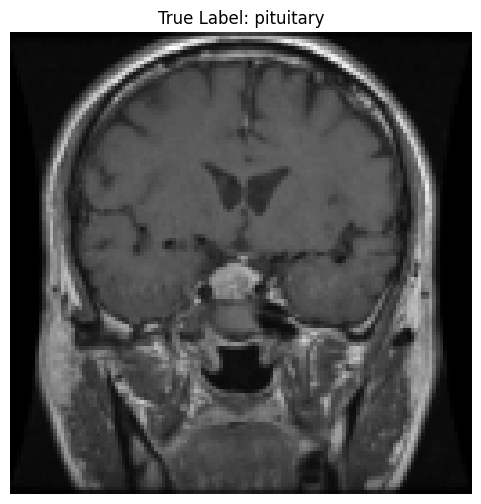

Predicted Class: pituitary
Predicted Class: pituitary


In [23]:
# Example prediction
predicted_class = predict_single_image(model_cnn, test_set, device)
print(f'Predicted Class: {predicted_class}')

We can now plot the confusion matrix of our predictions to understand if our model performs well/poorly for certain classes.

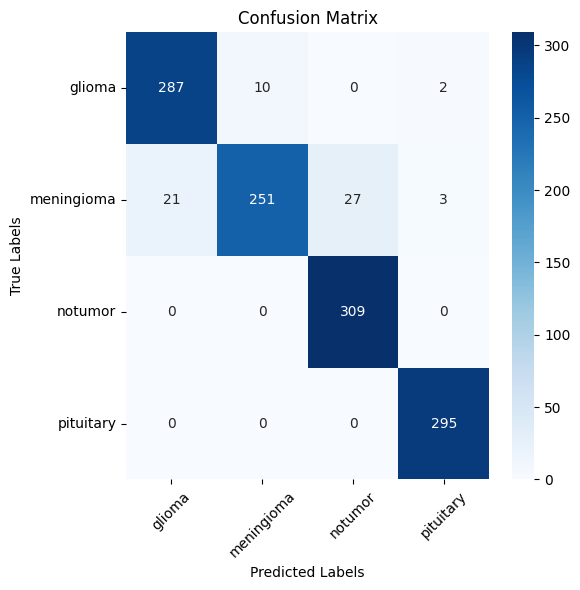

In [24]:
confusion_matrix = conf_matrix(model_cnn, test_set, label_conversion_dict)

In [25]:
summary(confusion_matrix, class_labels)

Summary: 

We have 

93.18% accuracy rate for predicting glioma.
If glioma is predicted, the true class of the predicted image could be:
meningioma with 6.82% chance
notumor with 0.00% chance
pituitary with 0.00% chance


96.17% accuracy rate for predicting meningioma.
If meningioma is predicted, the true class of the predicted image could be:
glioma with 3.83% chance
notumor with 0.00% chance
pituitary with 0.00% chance


91.96% accuracy rate for predicting notumor.
If notumor is predicted, the true class of the predicted image could be:
glioma with 0.00% chance
meningioma with 8.04% chance
pituitary with 0.00% chance


98.33% accuracy rate for predicting pituitary.
If pituitary is predicted, the true class of the predicted image could be:
glioma with 0.67% chance
meningioma with 1.00% chance
notumor with 0.00% chance


